In [42]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *
from relation_graph import *

### Vocabulary Module

In [71]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [44]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

### Situtation Module

In [45]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [46]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

### World Module with Mini-Gym

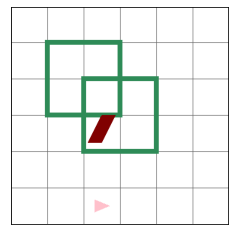

In [47]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'

world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")

# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=1, column=1))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=3, column=2))
world.place_agent_at(Position(row=5, column=2))
_ = world.render_simple()

In [48]:
verb = "push"
adverb = "cautiously"

# Direct walk.
action = "walk" # this is definit!
primitive_command = vocabulary.translate_word(action)
target_position = Position(row=3, column=2)
# simulator._world.get_current_situation().to_dict()["target_object"].position
world.go_to_position(position=target_position, manner=adverb, primitive_command=primitive_command)

# Object actions.
if True:
    semantic_action = vocabulary.translate_word(verb)
    world.move_object_to_wall(action=semantic_action, manner=adverb)
target_commands, target_demonstration = world.get_current_observations()

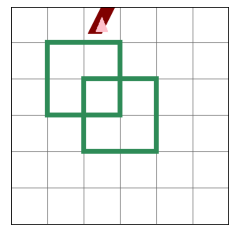

In [49]:
_ = world.render_simple()

### ReaSCAN Grammer Module

In [50]:
grammer = Grammer(vocabulary)
vocabulary.get_transitive_verbs() + vocabulary.get_intransitive_verbs()

['push', 'pull', 'walk']

In [51]:
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'

relations = grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph(grammer_pattern))

command_structs = []
for relation in relations:
    obj_pattern_map = relation[0]
    rel_map = relation[1]
    grammer_bindings = grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)
    for obj_map in grammer_bindings:
        # here, we also sample the verb and adverb bindings!
        
        command_struct = {
            "obj_pattern_map" : obj_pattern_map,
            "rel_map" : rel_map,
            "obj_map" : obj_map,
            "grammer_pattern" : grammer_pattern,
            "adverb" : random.choice(vocabulary.get_adverbs()),
            "verb" : random.choice(vocabulary.get_transitive_verbs() + vocabulary.get_intransitive_verbs()),
        }
        command_structs += [command_struct]

In [75]:
vocabulary.get_transitive_verbs()

['push', 'pull']

In [52]:
# command_struct_stats = get_command_struct_statistics(command_structs)

### ReaSCAN Simulator

In [53]:
simulator = Simulator(
    object_vocabulary, vocabulary, 
    grid_size=6, 
    n_object_max=10,
)

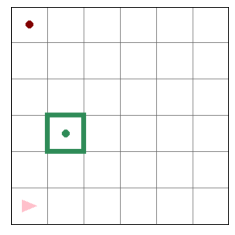

In [66]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_SHAPE', ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'}
obj_map = {'$OBJ_0': 'object', '$OBJ_1': 'circle', '$OBJ_2': 'box'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
verb = "push"
adverb = "slowly"
sampled_world = simulator.sample_situations_from_grounded_grammer(
    copy.deepcopy(grammer_pattern), 
    copy.deepcopy(obj_pattern_map), 
    copy.deepcopy(rel_map), 
    copy.deepcopy(obj_map),
    is_plot=True,
    include_relation_distractor=False, 
    include_attribute_distractor=False, 
    include_isomorphism_distractor=False, 
    include_random_distractor=False,
    full_relation_probability=0.5,
    debug=False
)

In [67]:
is_transitive = False
if verb in simulator.vocabulary.get_transitive_verbs():
    is_transitive = True

# Direct walk.
action = "walk" # this is definit!
primitive_command = simulator.vocabulary.translate_word(action)
target_position = sampled_world["situation"].target_object.position

simulator._world.go_to_position(position=target_position, manner=adverb, primitive_command=primitive_command)

# Object actions.
if is_transitive:
    semantic_action = simulator.vocabulary.translate_word(verb)
    simulator._world.move_object_to_wall(action=semantic_action, manner=adverb)
target_commands, target_demonstration = simulator._world.get_current_observations()

In [68]:
target_commands

['walk', 'turn left', 'walk', 'walk', 'push', 'push', 'push']

### End-to-end Task Generation

1 / 3 unique solution find!


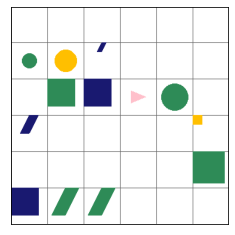

In [19]:
obj_pattern_map = {'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_COLUMN', ('$OBJ_0', '$OBJ_2'): '$SAME_ROW'}
obj_map = {'$OBJ_0': 'square', '$OBJ_1': 'circle', '$OBJ_2': 'cylinder'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
verb = "walk"
adverb = "cautiously"

test_unique_find = 0
for i in range(200):
    sampled_world = simulator.sample_situations_from_grounded_grammer(
        copy.deepcopy(grammer_pattern), 
        copy.deepcopy(obj_pattern_map), 
        copy.deepcopy(rel_map), 
        copy.deepcopy(obj_map),
        is_plot=False,
        include_relation_distractor=True, 
        include_attribute_distractor=True, 
        include_isomorphism_distractor=True, 
        include_random_distractor=True,
        full_relation_probability=0.5,
        debug=False
    )

    graph = ReaSCANGraph(
        objects=sampled_world["obj_map"], 
        object_patterns=sampled_world["obj_pattern_map"], 
        vocabulary=vocabulary,
        positions=sampled_world["pos_map"], 
        referred_object=sampled_world["referred_obj"],
        debug=False
    )

    pattern_graph = ReaSCANGraph(
        objects=obj_map, 
        object_patterns=None,
        vocabulary=vocabulary,
        relations=rel_map, 
        referred_object='$OBJ_0', 
        debug=False
    )

    potential_referent_target = graph.find_referred_object(
        pattern_graph, referred_object='$OBJ_0', 
        debug=False
    )

    if len(potential_referent_target) == 1:
        print(f"{test_unique_find+1} / {i+1} unique solution find!")
        test_unique_find += 1
        
        simulator._world.render_simple()
        
        obj_determiner_map = graph.find_determiners(
            pattern_graph, 
            referred_object='$OBJ_0', 
            debug=False,
        )
        
        command_str = grammer.repre_str_command(
            grammer_pattern, rel_map, obj_map, 
            obj_determiner_map, 
            verb,
            adverb,
        )
        
        # Get the target command
        is_transitive = False
        if verb in simulator.vocabulary.get_transitive_verbs():
            is_transitive = True
        
        # Direct walk.
        action = "walk" # this is definit!
        primitive_command = simulator.vocabulary.translate_word(action)
        target_position = sampled_world["situation"].target_object.position

        simulator._world.go_to_position(
            position=target_position, manner=adverb, 
            primitive_command=primitive_command
        )

        # Object actions.
        if is_transitive:
            semantic_action = simulator.vocabulary.translate_word(verb)
            simulator._world.move_object_to_wall(action=semantic_action, manner=adverb)
        target_commands, _ = simulator._world.get_current_observations()
        
        task_struct = OrderedDict({
            "command": ",".join(command_str.split(" ")),
            "meaning": ",".join(command_str.split(" ")),
            "derivation": grammer_pattern,
            "situation": sampled_world["situation"].to_representation(),
            "target_commands": ",".join(target_commands),
            "verb_in_command": verb,
            "adverb_in_command": adverb,
            "referred_target": obj_map["$OBJ_0"],
            "object_pattern_map": obj_pattern_map,
            "relation_map": rel_map,
            "object_expression": obj_map,
            "n_object": len(sampled_world["obj_map"]),
            "n_distractor": len(sampled_world["obj_map"])-len(obj_map),
            "full_relation_distractor": True if len(sampled_world["distractor_switch_map"]["relation"]) == len(rel_map) else False,
            "has_relation_distractor": True if len(sampled_world["distractor_switch_map"]["relation"]) > 0 else False,
            "has_attribute_distractor": sampled_world["distractor_switch_map"]["attribute"],
            "has_isomorphism_distractor": sampled_world["distractor_switch_map"]["isomorphism"],
            "has_random_distractor": True if sampled_world["n_random_distractor"] != -1 else False,
            "n_random_distractor": sampled_world["n_random_distractor"] if sampled_world["n_random_distractor"] != -1 else 0,
            "relation_distractor_metadata": sampled_world["relation_distractor_metadata"],
            "attribute_distractor_metadata": sampled_world["attribute_distractor_metadata"],
            "isomorphism_distractor_metadata": sampled_world["isomorphism_distractor_metadata"],
            "random_distractor_metadata": sampled_world["random_distractor_metadata"],
        })
        
        break